In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import lightgbm as lgbm, catboost as catb

from catboost import cv, Pool

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

import featuretools as ft
import featuretools.variable_types as vtypes

import pickle

import seaborn as sns
%matplotlib inline

#### 0. Загрузка данных

In [2]:
df = pd.read_csv('./course_project_train.csv', encoding='utf-8')
df_final = pd.read_csv('./course_project_test.csv', encoding='utf-8')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

Скрипт уменьшающий размер датасета путем изменения типов данных в датасете

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [6]:
reduce_mem_usage(df)
reduce_mem_usage(df_final)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%
Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.500000,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.700001,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.700000,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.000000,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.600000,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.100000,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,100000000.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.000000,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.800000,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.799999,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


### 1 Обзор датасета

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                7500 non-null   category
 1   Annual Income                 5943 non-null   float32 
 2   Years in current job          7129 non-null   category
 3   Tax Liens                     7500 non-null   float32 
 4   Number of Open Accounts       7500 non-null   float32 
 5   Years of Credit History       7500 non-null   float32 
 6   Maximum Open Credit           7500 non-null   float32 
 7   Number of Credit Problems     7500 non-null   float32 
 8   Months since last delinquent  3419 non-null   float32 
 9   Bankruptcies                  7486 non-null   float32 
 10  Purpose                       7500 non-null   category
 11  Term                          7500 non-null   category
 12  Current Loan Amount           7500 non-null   fl

In [8]:
target = 'Credit Default'
cat_features = ['Home Ownership','Years in current job','Purpose','Term']
num_features = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit','Number of Credit Problems',
                'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

cat_and_num = cat_features + num_features


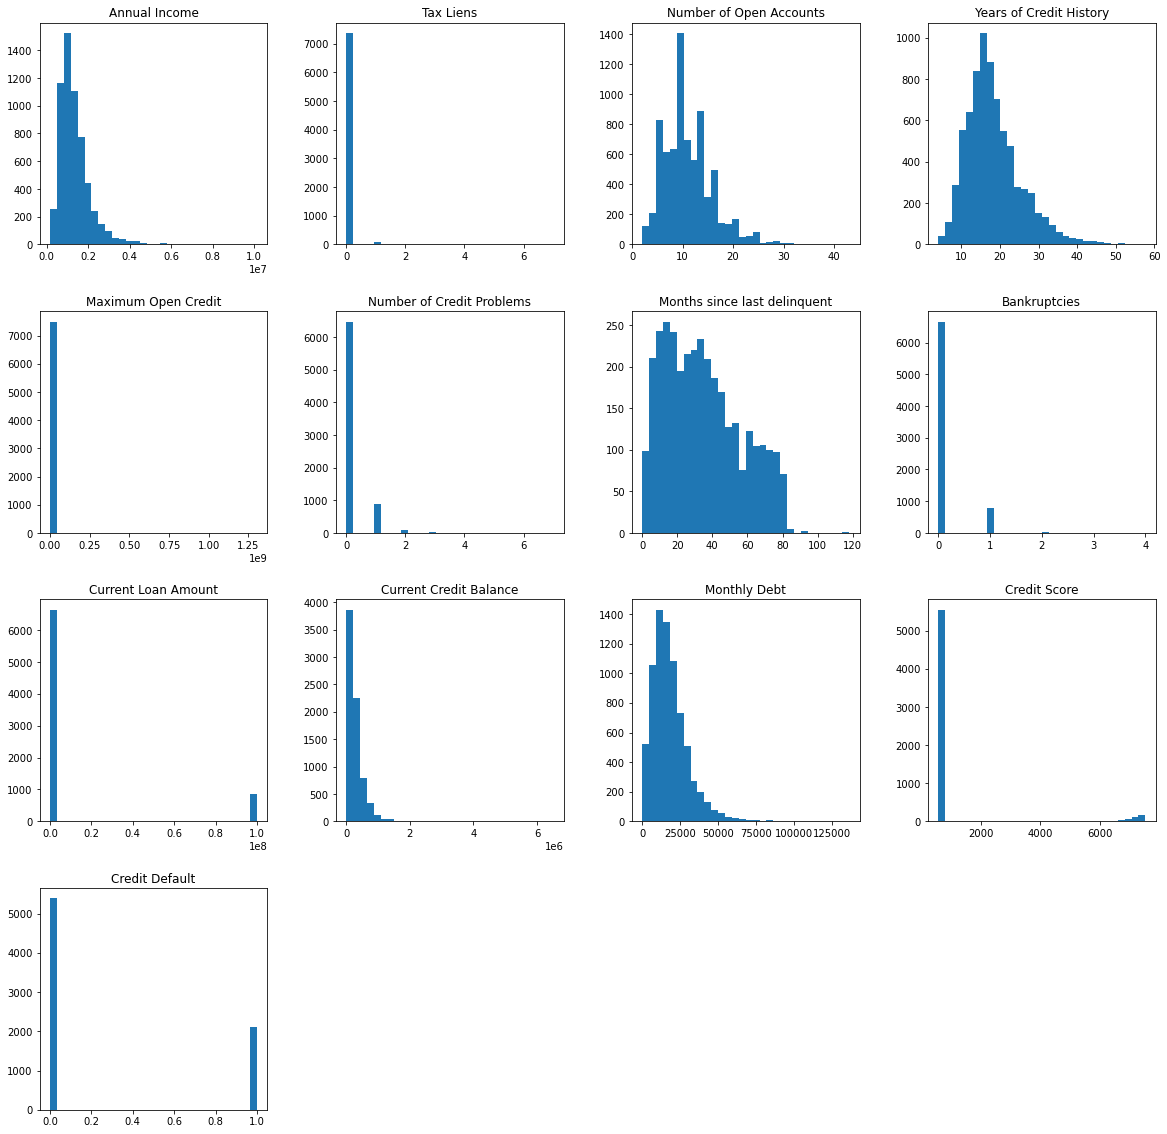

In [9]:
df.hist(figsize=(20,20), bins=30, grid=False);

In [10]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524,0.281733
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


В признаке Credit Score виден выброс 

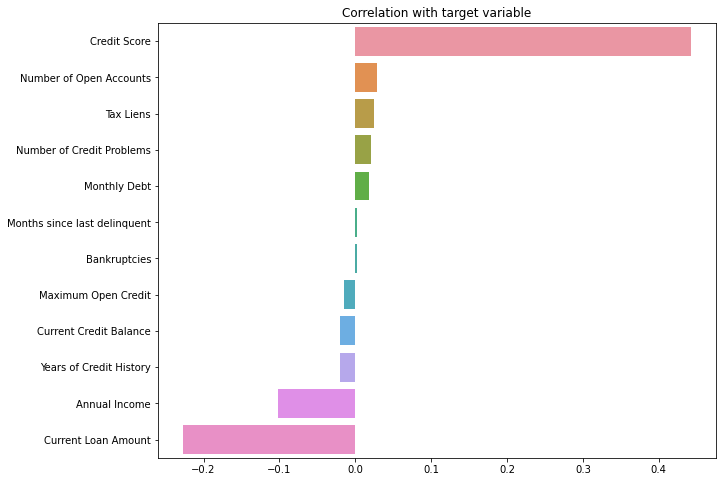

In [11]:
corr_with_target = df.corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [12]:
len(df) - df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [13]:
df = df.drop(['Months since last delinquent'], axis=1) ### У признака много пропусков и он слабо корелирует с целевой переменной его можно удалить 
df.drop(df.loc[(df['Annual Income'].isna()) &(df['Credit Score'].isna())].index, inplace=True)
df['Bankruptcies'] = df['Bankruptcies'].fillna(0)
df.loc[(df['Years in current job'].isna())] 
df['Years in current job'].fillna(df['Years in current job'].mode().values[0], inplace = True)
#df.loc[df['Credit Score'] > 900, 'Credit Score'] /= 10

In [14]:
len(df) - df.count()

Home Ownership               0
Annual Income                0
Years in current job         0
Tax Liens                    0
Number of Open Accounts      0
Years of Credit History      0
Maximum Open Credit          0
Number of Credit Problems    0
Bankruptcies                 0
Purpose                      0
Term                         0
Current Loan Amount          0
Current Credit Balance       0
Monthly Debt                 0
Credit Score                 0
Credit Default               0
dtype: int64

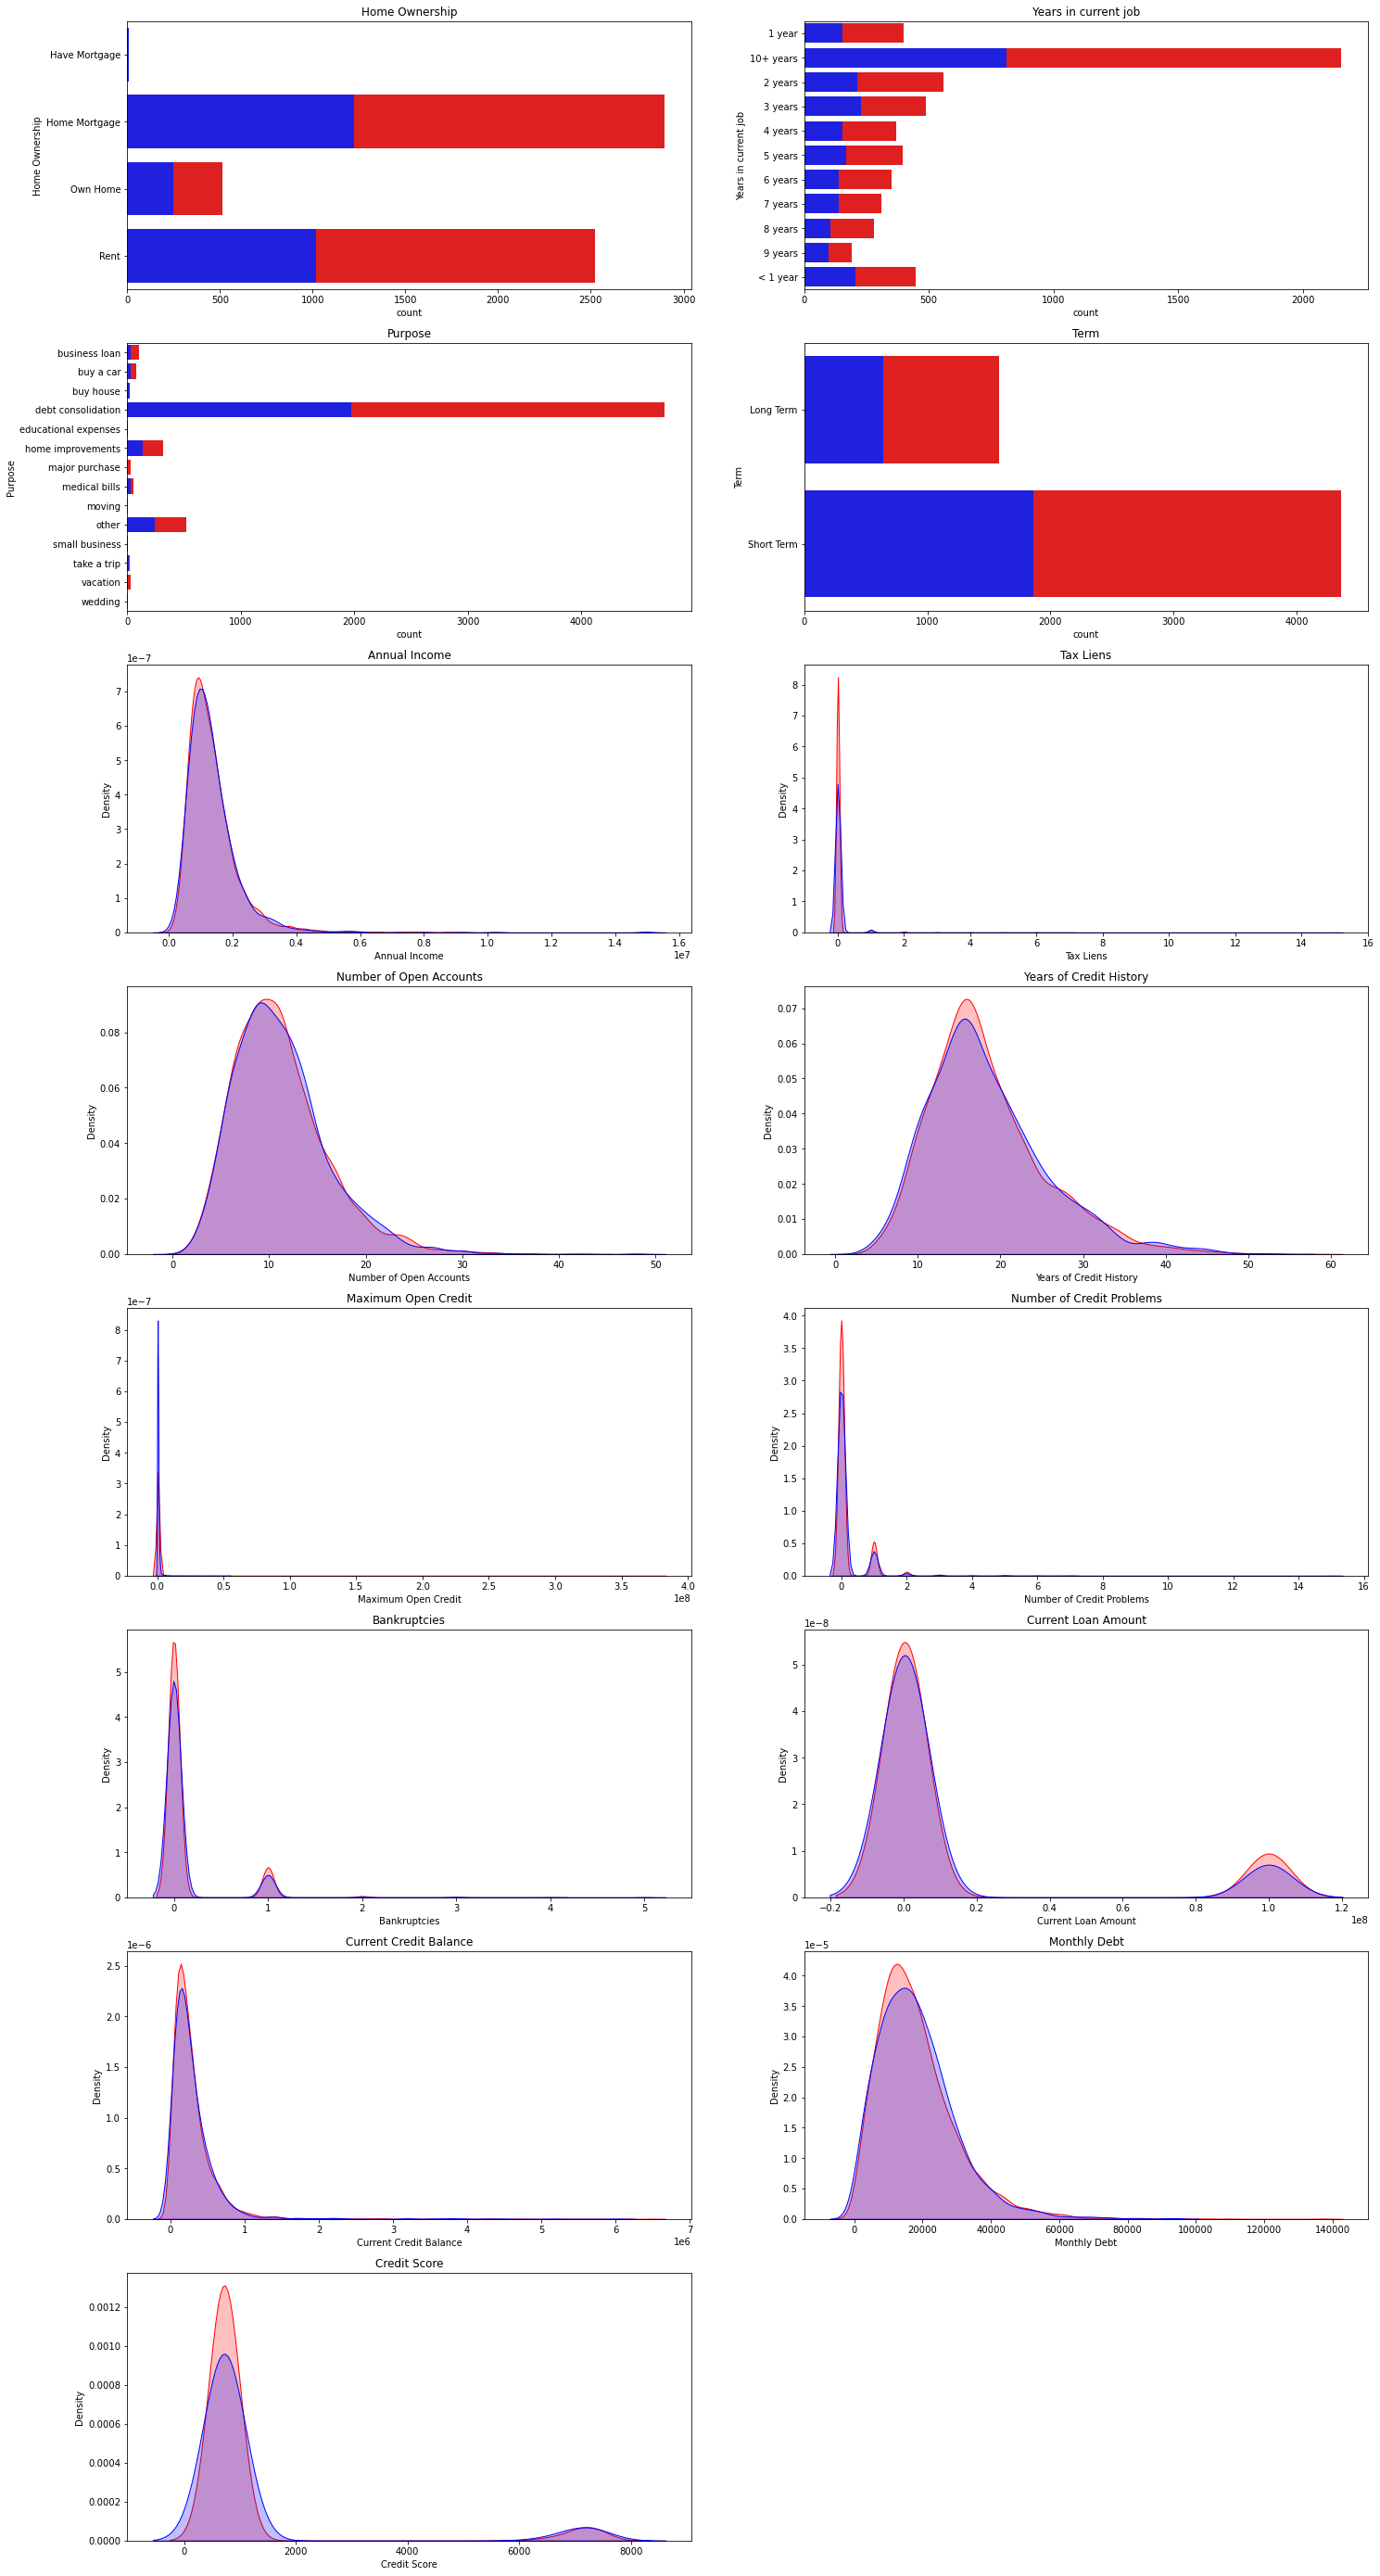

In [15]:
plt.figure(figsize = (24, 50))

l = len(cat_and_num)

for i in range(l):
    plt.subplot((l+1)//2,2,i+1)
    plt.title(cat_and_num[i])
    if df[cat_and_num[i]].dtype == 'float32':
        sns.kdeplot(df[cat_and_num[i]], shade=True, label='train', color='r')
        sns.kdeplot(df_final[cat_and_num[i]], shade=True, label='test', color='b')
    else:
        sns.countplot(y=cat_and_num[i], data=df, color = 'r')
        sns.countplot(y=cat_and_num[i], data=df_final, color = 'b')

plt.show()

Стандартизируем датасет

In [16]:
scaler = StandardScaler()

df_norm = df.copy()
df_norm[num_features] = scaler.fit_transform(df_norm[num_features])

df = df_norm.copy()

Так как в наборе данных дисбаланс классов , произведем балансировку

In [17]:
df_balanced = balance_df_by_target(df, 'Credit Default')
    
print(df_balanced['Credit Default'].value_counts())

X = df_balanced.drop(columns='Credit Default')
y = df_balanced['Credit Default']

0    4359
1    3168
Name: Credit Default, dtype: int64


Сгенерируем признаки при поможи библиотеки FeatureTools

In [18]:
es = ft.EntitySet(id='Credits')
es

Entityset: Credits
  Entities:
  Relationships:
    No relationships

In [19]:
cols = num_features + cat_features
es.entity_from_dataframe(entity_id='Clients',
                         dataframe=X,
                         index='index')

/opt/conda/lib/python3.8/site-packages/featuretools/entityset/entity.py:462: UserWarning: index index not found in dataframe, creating new integer column
  warnings.warn("index {} not found in dataframe, creating new "


Entityset: Credits
  Entities:
    Clients [Rows: 7527, Columns: 16]
  Relationships:
    No relationships

In [20]:
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Tax Liens', index='Tax Liens')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Number of Open Accounts', index='Number of Open Accounts')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Number of Credit Problems', index='Number of Credit Problems')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Bankruptcies', index='Bankruptcies')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Home Ownership', index='Home Ownership')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Years in current job', index='Years in current job')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Purpose', index='Purpose')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Term', index='Term')

In [21]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
                                       target_entity ='Clients',
                                       verbose=3, 
                                       n_jobs=-1)

Built 471 features
EntitySet scattered to 2 workers in 2 seconds
Elapsed: 00:03 | Progress: 100%|██████████


In [22]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_names, include_unknown=False)

In [23]:
train_featured = feature_matrix_enc.copy()
X_featured = pd.get_dummies(train_featured)
X_featured.reset_index(drop=True)

,Home Ownership = Home Mortgage,Home Ownership = Rent,Home Ownership = Own Home,Home Ownership = Have Mortgage,Annual Income,Years in current job = 10+ years,Years in current job = 2 years,Years in current job = 3 years,Years in current job = < 1 year,Years in current job = 5 years,...,Term.STD(Clients.Maximum Open Credit),Term.STD(Clients.Monthly Debt),Term.STD(Clients.Years of Credit History),Term.SUM(Clients.Annual Income),Term.SUM(Clients.Credit Score),Term.SUM(Clients.Current Credit Balance),Term.SUM(Clients.Current Loan Amount),Term.SUM(Clients.Maximum Open Credit),Term.SUM(Clients.Monthly Debt),Term.SUM(Clients.Years of Credit History)
0,False,True,False,False,-1.063985,False,True,False,False,False,...,1.050642,0.969590,1.021194,-519.240975,656.758492,-427.964294,-161.654312,-42.001976,-496.602012,-193.250162
1,True,False,False,False,-1.082822,False,True,False,False,False,...,1.050642,0.969590,1.021194,-519.240975,656.758492,-427.964294,-161.654312,-42.001976,-496.602012,-193.250162
2,False,False,True,False,-0.241827,False,False,False,False,True,...,0.179683,1.030518,0.962971,252.859541,504.804437,352.891605,-493.815365,-16.747901,533.617182,151.055359
3,True,False,False,False,-0.149015,False,False,False,True,False,...,1.050642,0.969590,1.021194,-519.240975,656.758492,-427.964294,-161.654312,-42.001976,-496.602012,-193.250162
4,True,False,False,False,1.456774,False,False,True,False,False,...,0.179683,1.030518,0.962971,252.859541,504.804437,352.891605,-493.815365,-16.747901,533.617182,151.055359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7522,False,False,True,False,-0.606197,False,False,False,True,False,...,1.050642,0.969590,1.021194,-519.240975,656.758492,-427.964294,-161.654312,-42.001976,-496.602012,-193.250162
7523,True,False,False,False,-0.723959,False,False,False,False,False,...,0.179683,1.030518,0.962971,252.859541,504.804437,352.891605,-493.815365,-16.747901,533.617182,151.055359
7524,False,True,False,False,0.214276,False,False,False,False,False,...,1.050642,0.969590,1.021194,-519.240975,656.758492,-427.964294,-161.654312,-42.001976,-496.602012,-193.250162
7525,True,False,False,False,-0.473509,True,False,False,False,False,...,1.050642,0.969590,1.021194,-519.240975,656.758492,-427.964294,-161.654312,-42.001976,-496.602012,-193.250162


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_featured, y, shuffle=True, test_size=0.30, random_state=21)

Сравним модели 

In [25]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      3006
           1       0.99      0.94      0.96      2262

    accuracy                           0.97      5268
   macro avg       0.97      0.97      0.97      5268
weighted avg       0.97      0.97      0.97      5268

TEST

              precision    recall  f1-score   support

           0       0.84      0.85      0.84      1353
           1       0.77      0.75      0.76       906

    accuracy                           0.81      2259
   macro avg       0.80      0.80      0.80      2259
weighted avg       0.81      0.81      0.81      2259

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1153  200
1                227  679


In [26]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      3006
           1       0.97      0.87      0.92      2262

    accuracy                           0.93      5268
   macro avg       0.94      0.93      0.93      5268
weighted avg       0.93      0.93      0.93      5268

TEST

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      1353
           1       0.77      0.69      0.73       906

    accuracy                           0.79      2259
   macro avg       0.79      0.77      0.78      2259
weighted avg       0.79      0.79      0.79      2259

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1161  192
1                280  626
CPU times: user 23.5 s, sys: 1.69 s, total: 25.2 s
Wall time: 14.2 s


In [27]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    


In [28]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       model_catb.feature_importances_ / model_catb.feature_importances_.sum()), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

При помощи feature_importrances оставим признаки которые больше 0.005

In [ ]:
feature_above_zero = feature_importances[feature_importances['importance'] > 0.005]
feature_above_zero_filtred = feature_above_zero['feature_name'].tolist()

In [30]:
feature_above_zero

,feature_name,importance
63,Credit Score,0.311004
60,Current Loan Amount,0.181863
4,Annual Income,0.057839
62,Monthly Debt,0.046069
33,Years of Credit History,0.044581
34,Maximum Open Credit,0.040688
61,Current Credit Balance,0.033482


In [31]:
X_featured = X_featured[feature_above_zero_filtred]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_featured, y, shuffle=True, test_size=0.30, random_state=21)

In [33]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3006
           1       0.96      0.85      0.90      2262

    accuracy                           0.92      5268
   macro avg       0.93      0.91      0.92      5268
weighted avg       0.92      0.92      0.92      5268

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1353
           1       0.75      0.67      0.71       906

    accuracy                           0.78      2259
   macro avg       0.77      0.76      0.76      2259
weighted avg       0.78      0.78      0.78      2259

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1151  202
1                299  607
CPU times: user 3.8 s, sys: 469 ms, total: 4.27 s
Wall time: 2.87 s


Подберем гиперпараметры 

In [42]:
params = {'n_estimators':np.arange(200, 800, 5),
          'max_depth':np.arange(4, 10, 1),
          'learning_rate':np.arange(0.01, 0.15, 0.01)
         }

In [44]:
cv=KFold(n_splits=5, random_state=21, shuffle=True)

In [45]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_featured, y)

CPU times: user 10.5 s, sys: 731 ms, total: 11.3 s
Wall time: 2min 1s


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f45b42122e0>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14]),
                                        'max_depth': array([4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([200, 205, 210, 215, 220, 225, 230, 235, 24...
       330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390,
       395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455,
       460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520,
       525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585,
       590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650,
       655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715,
       720, 725, 730, 735, 740

In [46]:
rs.best_params_

{'n_estimators': 620, 'max_depth': 9, 'learning_rate': 0.12}

In [47]:
rs.best_score_

0.8619342899563176

In [49]:
%%time

final_model = catb.CatBoostClassifier(#class_weights=[1, 1.5],
                                      n_estimators=620, max_depth=9,
                                      learning_rate=0.12, l2_leaf_reg=20,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3006
           1       1.00      0.99      1.00      2262

    accuracy                           1.00      5268
   macro avg       1.00      1.00      1.00      5268
weighted avg       1.00      1.00      1.00      5268

TEST

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1353
           1       0.80      0.84      0.82       906

    accuracy                           0.85      2259
   macro avg       0.84      0.85      0.85      2259
weighted avg       0.85      0.85      0.85      2259

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1165  188
1                149  757
CPU times: user 8.63 s, sys: 610 ms, total: 9.24 s
Wall time: 5.37 s


Обучим финальную модель на всех данных с подобранными параметрами

In [51]:
%%time

final_model = catb.CatBoostClassifier(#class_weights=[1, 2],
                                      n_estimators=620, max_depth=9,
                                      learning_rate=0.12, l2_leaf_reg=20,
                                      silent=True, random_state=21)
final_model.fit(X_featured, y)

CPU times: user 9.5 s, sys: 661 ms, total: 10.2 s
Wall time: 5.97 s


In [52]:
with open('model.pkl', 'wb') as file:
    pickle.dump(final_model, file)

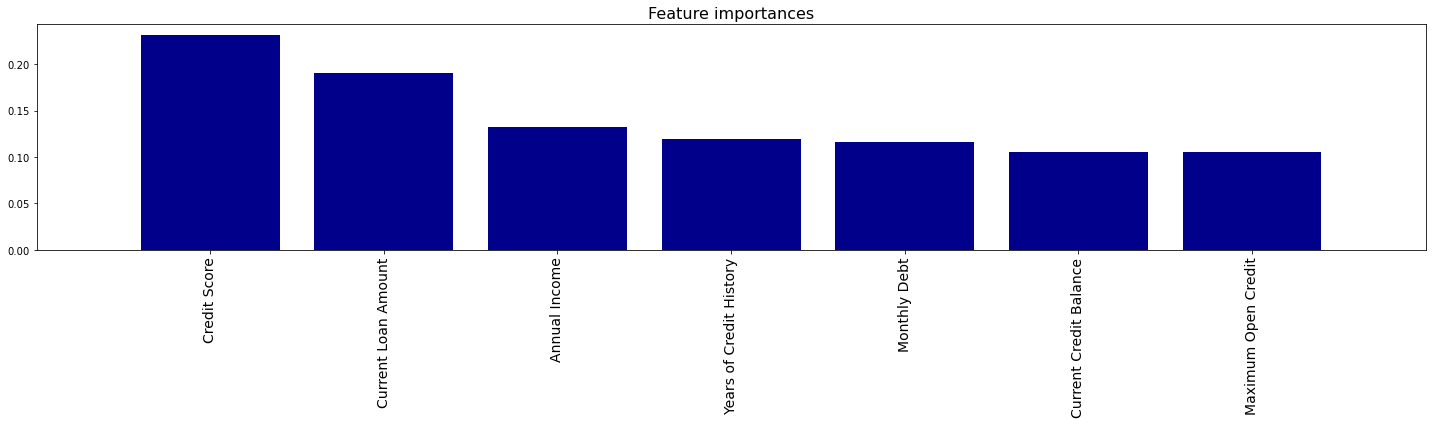

In [53]:
plot_feature_importances(importances = final_model.feature_importances_, X=X_featured)

#### Работа с тестовым датасетом

In [54]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Home Ownership                2500 non-null   category
 1   Annual Income                 1987 non-null   float32 
 2   Years in current job          2414 non-null   category
 3   Tax Liens                     2500 non-null   float32 
 4   Number of Open Accounts       2500 non-null   float32 
 5   Years of Credit History       2500 non-null   float32 
 6   Maximum Open Credit           2500 non-null   float32 
 7   Number of Credit Problems     2500 non-null   float32 
 8   Months since last delinquent  1142 non-null   float32 
 9   Bankruptcies                  2497 non-null   float32 
 10  Purpose                       2500 non-null   category
 11  Term                          2500 non-null   category
 12  Current Loan Amount           2500 non-null   fl

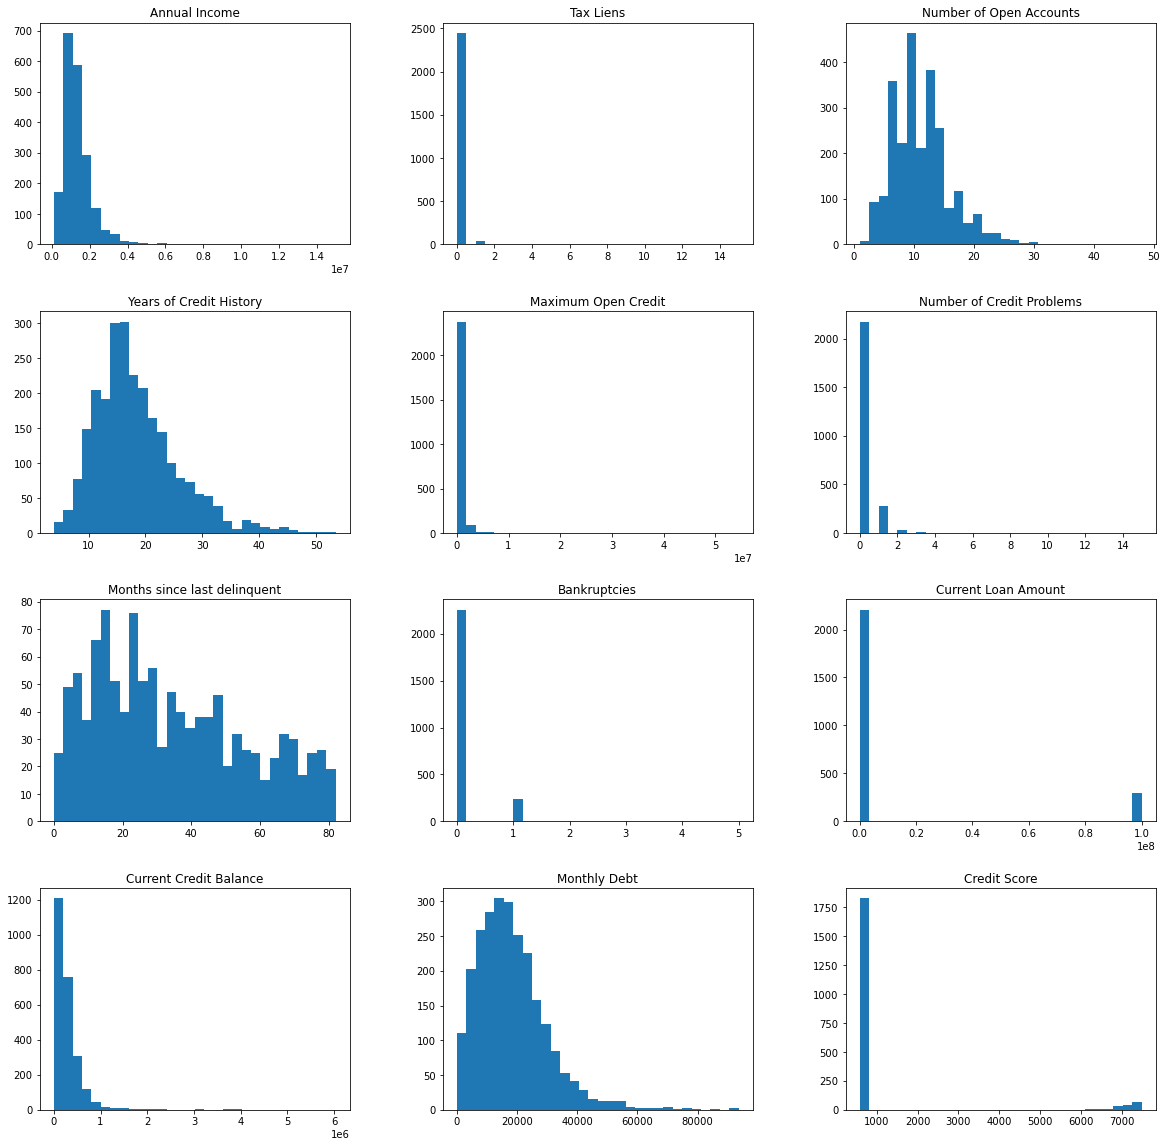

In [55]:
df_final.hist(figsize=(20,20), bins=30, grid=False);

In [56]:
len(df_final) - df_final.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

In [57]:
df_final

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.500000,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.700001,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.700000,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.000000,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.600000,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.100000,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,100000000.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.000000,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.800000,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.799999,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0


In [58]:
df_final = df_final.drop(['Months since last delinquent'], axis=1)

In [ ]:
#df_final.drop(df_final.loc[(df_final['Annual Income'].isna()) &(df_final['Credit Score'].isna())].index, inplace=True)

In [59]:
df_final['Bankruptcies'] = df_final['Bankruptcies'].fillna(0)

In [60]:
df_final.loc[(df_final['Years in current job'].isna())] 

df_final['Years in current job'].fillna(df_final['Years in current job'].mode().values[0], inplace = True)
#df_final.loc[df_final['Credit Score'] > 900, 'Credit Score'] /= 10

In [61]:
len(df_final) - df_final.count()

Home Ownership                 0
Annual Income                513
Years in current job           0
Tax Liens                      0
Number of Open Accounts        0
Years of Credit History        0
Maximum Open Credit            0
Number of Credit Problems      0
Bankruptcies                   0
Purpose                        0
Term                           0
Current Loan Amount            0
Current Credit Balance         0
Monthly Debt                   0
Credit Score                 513
dtype: int64

In [62]:
### df_final

In [63]:
scaler = StandardScaler()

df_norm = df_final.copy()
df_norm[num_features] = scaler.fit_transform(df_norm[num_features])

df_final = df_norm.copy()

In [64]:
es = ft.EntitySet(id='Credits')
es

Entityset: Credits
  Entities:
  Relationships:
    No relationships

In [65]:
cols = num_features + cat_features
es.entity_from_dataframe(entity_id='Clients',
                         dataframe=df_final,
                         index='Id')

/opt/conda/lib/python3.8/site-packages/featuretools/entityset/entity.py:462: UserWarning: index Id not found in dataframe, creating new integer column
  warnings.warn("index {} not found in dataframe, creating new "


Entityset: Credits
  Entities:
    Clients [Rows: 2500, Columns: 16]
  Relationships:
    No relationships

In [66]:
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Tax Liens', index='Tax Liens')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Number of Open Accounts', index='Number of Open Accounts')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Number of Credit Problems', index='Number of Credit Problems')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Bankruptcies', index='Bankruptcies')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Home Ownership', index='Home Ownership')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Years in current job', index='Years in current job')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Purpose', index='Purpose')
es = es.normalize_entity(base_entity_id='Clients', new_entity_id='Term', index='Term')

es

Entityset: Credits
  Entities:
    Clients [Rows: 2500, Columns: 16]
    Tax Liens [Rows: 8, Columns: 1]
    Number of Open Accounts [Rows: 35, Columns: 1]
    Number of Credit Problems [Rows: 8, Columns: 1]
    Bankruptcies [Rows: 6, Columns: 1]
    Home Ownership [Rows: 4, Columns: 1]
    Years in current job [Rows: 11, Columns: 1]
    Purpose [Rows: 14, Columns: 1]
    Term [Rows: 2, Columns: 1]
  Relationships:
    Clients.Tax Liens -> Tax Liens.Tax Liens
    Clients.Number of Open Accounts -> Number of Open Accounts.Number of Open Accounts
    Clients.Number of Credit Problems -> Number of Credit Problems.Number of Credit Problems
    Clients.Bankruptcies -> Bankruptcies.Bankruptcies
    Clients.Home Ownership -> Home Ownership.Home Ownership
    Clients.Years in current job -> Years in current job.Years in current job
    Clients.Purpose -> Purpose.Purpose
    Clients.Term -> Term.Term

In [67]:
feature_matrix, feature_names = ft.dfs(entityset=es, 
                                       target_entity ='Clients',
                                       verbose=3, 
                                       n_jobs=-1)

Built 471 features
EntitySet scattered to 2 workers in 2 seconds
Elapsed: 00:02 | Progress: 100%|██████████


In [68]:
feature_matrix_enc, features_enc = ft.encode_features(feature_matrix, feature_names, include_unknown=False)

In [69]:
train_featured = feature_matrix_enc.copy()
df_final = pd.get_dummies(train_featured)

In [70]:
df_final = df_final[feature_above_zero_filtred]

In [71]:
df_final

,Credit Score,Current Loan Amount,Annual Income,Monthly Debt,Years of Credit History,Maximum Open Credit,Current Credit Balance
Id,,,,,,,
0,NaN,-0.371832,NaN,-0.992788,-0.803220,-0.323879,-0.503642
1,-0.307807,-0.374441,-1.237966,-1.382250,1.981755,-0.433044,-0.661931
2,3.463356,-0.370663,-0.233813,0.039653,-0.637776,-0.334707,-0.396341
3,-0.284816,-0.370129,-0.159897,0.804714,-0.182805,-0.168202,-0.219968
4,-0.303783,-0.352759,1.062315,2.108349,0.727138,0.328576,0.341051
...,...,...,...,...,...,...,...
2495,-0.281367,2.723472,-0.378308,-0.279454,1.485423,-0.100166,-0.353391
2496,NaN,-0.362343,NaN,1.275793,-0.182805,0.679515,3.021663
2497,-0.310106,-0.363522,-0.212801,1.615088,-0.761859,0.658776,1.004799


In [72]:
preds_final = pd.DataFrame()
preds_final['Id'] = df_final.index.copy()

In [74]:
y_pred_final = final_model.predict(df_final)

preds_final['Credit Default'] = y_pred_final
preds_final.to_csv('Kuznetsov_predictions.csv', index=False)

preds_final.describe()

,Id,Credit Default
count,2500.00000,2500.000000
mean,1249.50000,0.187600
std,721.83216,0.390471
min,0.00000,0.000000
25%,624.75000,0.000000
50%,1249.50000,0.000000
75%,1874.25000,0.000000
max,2499.00000,1.000000
